**Import and install Required Libraries**

In [ ]:
!pip install keras
!pip install tensorflow

In [ ]:
# Import required libraries

import keras                                   # Deep learning library
import matplotlib.pyplot as plt               # Library for creating data visualizations
import string                                  # Library for string constants and operations
import re                                      # Library for regular expressions
import pandas as pd                            # Library for data manipulation and analysis


from keras.models import Sequential            # Keras model type for creating models layer-by-layer
from numpy import array, argmax, random, take  # Library for multi-dimensional arrays and matrices
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed  # Keras layers for neural networks
from keras.callbacks import ModelCheckpoint   # Keras callback for saving the model after every epoch
from keras.preprocessing.text import Tokenizer # Keras class for text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences # Keras function for padding sequences
from keras.models import load_model            # Keras function for loading a saved model
from keras import optimizers                   # Keras module for optimization algorithms


%matplotlib inline                             # Command for displaying plots inline in Jupyter notebooks
# Set option to display maximum column width in pandas
pd.set_option('display.max_colwidth', 200)


**Reading the Data**

We have a text file named deu.txt which has the Engilsg-German sentences pairs. We have to first read the file using the function defined below.

In [8]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now we will define a function to split this file into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences in order to view the Data we have

In [9]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

The data "deu.txt" in your working directory of the github

In [11]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The dataset we're working with contains over 150,000 sentence pairs, but for the purposes of reducing the training time of our model, we'll be using only the first 50,000 pairs. Feel free to adjust this number based on your system's computational power.

In [12]:
deu_eng = deu_eng[:50000,:]

**Start Pre-processing**

To clean the text we need to look at the data and then decide what approach should we take for pre-processing.

In [13]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['She watched him swim.', 'Sie hat ihm beim Schwimmen zugesehen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #887579 (CK) & #1354024 (Esperantostern)'],
       ['She went on a picnic.', 'Sie ist zu einem Picknick gegangen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #312052 (CK) & #1475963 (Zaghawa)'],
       ['She went on speaking.', 'Sie sprach weiter.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317518 (CK) & #814982 (Manfredo)']],
      dtype='<U537')

To get rid of the puncuation and upper case letter we do as follows.

In [14]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [15]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['She watched him swim', 'Sie hat ihm beim Schwimmen zugesehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #887579 (CK) & #1354024 (Esperantostern)'],
       ['She went on a picnic', 'Sie ist zu einem Picknick gegangen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #312052 (CK) & #1475963 (Zaghawa)'],
       ['She went on speaking', 'Sie sprach weiter',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317518 (CK) & #814982 (Manfredo)']],
      dtype='<U537')

In [16]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [17]:
deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['she watched him swim', 'sie hat ihm beim schwimmen zugesehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #887579 (CK) & #1354024 (Esperantostern)'],
       ['she went on a picnic', 'sie ist zu einem picknick gegangen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #312052 (CK) & #1475963 (Zaghawa)'],
       ['she went on speaking', 'sie sprach weiter',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #317518 (CK) & #814982 (Manfredo)']],
      dtype='<U537')

**Text to Sequence Conversion**

In order to prepare our data for a Seq2Seq model, we need to convert both the input and output sentences into fixed-length integer sequences. But before we do that, let's visualize the length of the sentences. To do this, we'll create two separate lists - one for English sentences and one for German sentences - to capture the lengths of all the sentences in each language.

In [18]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [20]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

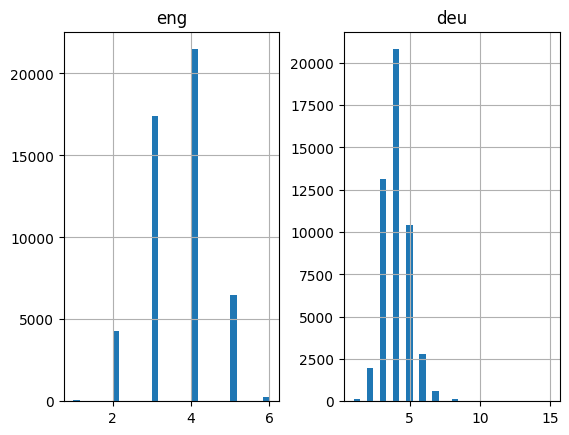

In [21]:
length_df.hist(bins = 30)
plt.show()

After visualizing the lengths of the German and English sentences, we found that the maximum length of German sentences is 11 and the maximum length of English phrases is 8.

To prepare our text data for modeling, we'll use Keras's Tokenizer() class to vectorize our sentences into sequences of integers. We'll then pad these sequences with zeros to make them all the same length, ensuring compatibility with our Seq2Seq model.

In [22]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [23]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6096


In [24]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10038


Next, we have a function that prepares the sequences for modeling. This function will also perform padding to ensure all sequences have the same length, with the maximum length determined by the longest sentence in each language as mentioned earlier

In [25]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

**Model Building**

To train and evaluate our model, we'll now split our data into training and testing sets. We'll use the training set for model training and the testing set for model evaluation

In [26]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

Now, we'll proceed to encode our sentences. For the purposes of our Seq2Seq model, we'll encode the German sentences as the input sequences and the English sentences as the target sequences. We'll perform this encoding process for both our train and test datasets.

In [27]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [28]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Finally, it's time to define the architecture of our Seq2Seq model! For the encoder, we'll use an Embedding layer and an LSTM layer. For the decoder, we'll use another LSTM layer followed by a Dense layer. This architecture will enable us to effectively translate German sentences into English sentences.

In [29]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In this particular model, we'll be using the RMSprop optimizer. This is a popular choice for recurrent neural networks like ours, as it has been shown to work well for this type of architecture

In [30]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Before training our model, it's important to note that we've used 'sparse_categorical_crossentropy' as the loss function. We've made this choice because it allows us to use the target sequences as they are, rather than having to one-hot encode them. With such a large vocabulary, one-hot encoding could consume a significant amount of memory.

Now, we're ready to start training our model! We'll train it for 30 epochs, with a batch size of 512. Of course, you can experiment with these hyperparameters to see if different values work better for your specific use case. To save the best model with the lowest validation loss, we'll be using the ModelCheckpoint() function. Personally, I prefer this method over early stopping

In [31]:
filename = 'model.filetocheck'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 3.3376
Epoch 1: val_loss improved from inf to 2.75095, saving model to model.h1.24_jan_19


63/63 [==============================] - 347s 5s/step - loss: 3.3376 - val_loss: 2.7509
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.6887
Epoch 2: val_loss improved from 2.75095 to 2.64313, saving model to model.h1.24_jan_19


63/63 [==============================] - 317s 5s/step - loss: 2.6887 - val_loss: 2.6431
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.5044
Epoch 3: val_loss improved from 2.64313 to 2.51120, saving model to model.h1.24_jan_19


63/63 [==============================] - 346s 6s/step - loss: 2.5044 - val_loss: 2.5112
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 2.3285
Epoch 4: val_loss improved from 2.51120 to 2.32129, saving model to model.h1.24_jan_19


63/63 [==============================] - 373s 6s/step - loss: 2.3285 - val_loss: 2.3213
Epoch 5/30
63/63 [==============================] - ETA: 0s - loss: 2.1826
Epoch 5: val_loss improved from 2.32129 to 2.23513, saving model to model.h1.24_jan_19


63/63 [==============================] - 360s 6s/step - loss: 2.1826 - val_loss: 2.2351
Epoch 6/30
63/63 [==============================] - ETA: 0s - loss: 2.0519
Epoch 6: val_loss improved from 2.23513 to 2.11830, saving model to model.h1.24_jan_19


63/63 [==============================] - 356s 6s/step - loss: 2.0519 - val_loss: 2.1183
Epoch 7/30
63/63 [==============================] - ETA: 0s - loss: 1.9277
Epoch 7: val_loss improved from 2.11830 to 2.01953, saving model to model.h1.24_jan_19


63/63 [==============================] - 360s 6s/step - loss: 1.9277 - val_loss: 2.0195
Epoch 8/30
63/63 [==============================] - ETA: 0s - loss: 1.8189
Epoch 8: val_loss improved from 2.01953 to 1.96003, saving model to model.h1.24_jan_19


63/63 [==============================] - 353s 6s/step - loss: 1.8189 - val_loss: 1.9600
Epoch 9/30
63/63 [==============================] - ETA: 0s - loss: 1.7137
Epoch 9: val_loss improved from 1.96003 to 1.87003, saving model to model.h1.24_jan_19


63/63 [==============================] - 350s 6s/step - loss: 1.7137 - val_loss: 1.8700
Epoch 10/30
63/63 [==============================] - ETA: 0s - loss: 1.6130
Epoch 10: val_loss improved from 1.87003 to 1.80673, saving model to model.h1.24_jan_19


63/63 [==============================] - 336s 5s/step - loss: 1.6130 - val_loss: 1.8067
Epoch 11/30
63/63 [==============================] - ETA: 0s - loss: 1.5173
Epoch 11: val_loss improved from 1.80673 to 1.73828, saving model to model.h1.24_jan_19


63/63 [==============================] - 319s 5s/step - loss: 1.5173 - val_loss: 1.7383
Epoch 12/30
63/63 [==============================] - ETA: 0s - loss: 1.4254
Epoch 12: val_loss improved from 1.73828 to 1.68857, saving model to model.h1.24_jan_19


63/63 [==============================] - 322s 5s/step - loss: 1.4254 - val_loss: 1.6886
Epoch 13/30
63/63 [==============================] - ETA: 0s - loss: 1.3388
Epoch 13: val_loss improved from 1.68857 to 1.62109, saving model to model.h1.24_jan_19


63/63 [==============================] - 321s 5s/step - loss: 1.3388 - val_loss: 1.6211
Epoch 14/30
63/63 [==============================] - ETA: 0s - loss: 1.2567
Epoch 14: val_loss improved from 1.62109 to 1.57865, saving model to model.h1.24_jan_19


63/63 [==============================] - 320s 5s/step - loss: 1.2567 - val_loss: 1.5787
Epoch 15/30
63/63 [==============================] - ETA: 0s - loss: 1.1772
Epoch 15: val_loss improved from 1.57865 to 1.54208, saving model to model.h1.24_jan_19


63/63 [==============================] - 322s 5s/step - loss: 1.1772 - val_loss: 1.5421
Epoch 16/30
63/63 [==============================] - ETA: 0s - loss: 1.1039
Epoch 16: val_loss improved from 1.54208 to 1.49500, saving model to model.h1.24_jan_19


63/63 [==============================] - 318s 5s/step - loss: 1.1039 - val_loss: 1.4950
Epoch 17/30
63/63 [==============================] - ETA: 0s - loss: 1.0319
Epoch 17: val_loss improved from 1.49500 to 1.47038, saving model to model.h1.24_jan_19


63/63 [==============================] - 318s 5s/step - loss: 1.0319 - val_loss: 1.4704
Epoch 18/30
63/63 [==============================] - ETA: 0s - loss: 0.9624
Epoch 18: val_loss improved from 1.47038 to 1.43404, saving model to model.h1.24_jan_19


63/63 [==============================] - 316s 5s/step - loss: 0.9624 - val_loss: 1.4340
Epoch 19/30
63/63 [==============================] - ETA: 0s - loss: 0.8966
Epoch 19: val_loss improved from 1.43404 to 1.40587, saving model to model.h1.24_jan_19


63/63 [==============================] - 324s 5s/step - loss: 0.8966 - val_loss: 1.4059
Epoch 20/30
63/63 [==============================] - ETA: 0s - loss: 0.8343
Epoch 20: val_loss improved from 1.40587 to 1.38981, saving model to model.h1.24_jan_19


63/63 [==============================] - 317s 5s/step - loss: 0.8343 - val_loss: 1.3898
Epoch 21/30
63/63 [==============================] - ETA: 0s - loss: 0.7746
Epoch 21: val_loss improved from 1.38981 to 1.37596, saving model to model.h1.24_jan_19


63/63 [==============================] - 319s 5s/step - loss: 0.7746 - val_loss: 1.3760
Epoch 22/30
63/63 [==============================] - ETA: 0s - loss: 0.7166
Epoch 22: val_loss improved from 1.37596 to 1.33311, saving model to model.h1.24_jan_19


63/63 [==============================] - 319s 5s/step - loss: 0.7166 - val_loss: 1.3331
Epoch 23/30
63/63 [==============================] - ETA: 0s - loss: 0.6656
Epoch 23: val_loss improved from 1.33311 to 1.31713, saving model to model.h1.24_jan_19


63/63 [==============================] - 319s 5s/step - loss: 0.6656 - val_loss: 1.3171
Epoch 24/30
63/63 [==============================] - ETA: 0s - loss: 0.6136
Epoch 24: val_loss improved from 1.31713 to 1.29330, saving model to model.h1.24_jan_19


63/63 [==============================] - 324s 5s/step - loss: 0.6136 - val_loss: 1.2933
Epoch 25/30
63/63 [==============================] - ETA: 0s - loss: 0.5663
Epoch 25: val_loss improved from 1.29330 to 1.28749, saving model to model.h1.24_jan_19


63/63 [==============================] - 334s 5s/step - loss: 0.5663 - val_loss: 1.2875
Epoch 26/30
63/63 [==============================] - ETA: 0s - loss: 0.5207
Epoch 26: val_loss improved from 1.28749 to 1.26968, saving model to model.h1.24_jan_19


63/63 [==============================] - 321s 5s/step - loss: 0.5207 - val_loss: 1.2697
Epoch 27/30
63/63 [==============================] - ETA: 0s - loss: 0.4788
Epoch 27: val_loss improved from 1.26968 to 1.26709, saving model to model.h1.24_jan_19


63/63 [==============================] - 320s 5s/step - loss: 0.4788 - val_loss: 1.2671
Epoch 28/30
63/63 [==============================] - ETA: 0s - loss: 0.4406
Epoch 28: val_loss improved from 1.26709 to 1.26177, saving model to model.h1.24_jan_19


63/63 [==============================] - 332s 5s/step - loss: 0.4406 - val_loss: 1.2618
Epoch 29/30
63/63 [==============================] - ETA: 0s - loss: 0.4033
Epoch 29: val_loss improved from 1.26177 to 1.24701, saving model to model.h1.24_jan_19


63/63 [==============================] - 335s 5s/step - loss: 0.4033 - val_loss: 1.2470
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 0.3689
Epoch 30: val_loss did not improve from 1.24701
63/63 [==============================] - 307s 5s/step - loss: 0.3689 - val_loss: 1.2504


Comparing the training loss and the validation loss.

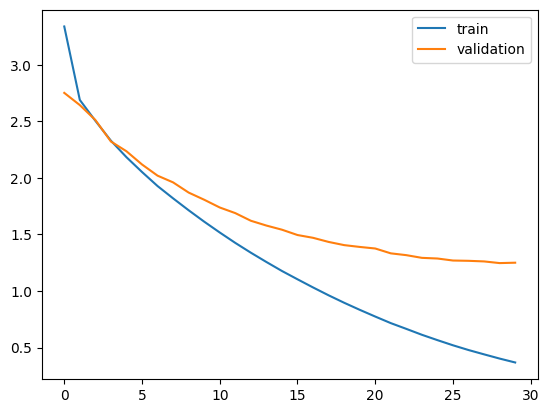

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

**Make Predictions**

Let's load the saved model to make predictions.

In [35]:
model = load_model('model.filetocheck')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
preds_classes = preds.argmax(axis=-1)


313/313 [==============================] - 49s 151ms/step


In [36]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [50]:
# convert predictions into text (English)
import numpy as np

preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(np.argmax(i[j]), eng_tokenizer)
        if j > 0:
            if (t == get_word(np.argmax(i[j-1]), eng_tokenizer)) or (t is None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t is None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))


In [51]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [52]:

pd.set_option('display.max_colwidth', 200)

In [53]:
pred_df.head(15)

,actual,predicted
0,today is a hot day,today is a day
1,tom knelt,tom kneeled
2,tom knows now,tom knows it now
3,nobody saw me,nobody one was me
4,try it out yourself,try it a yourself
5,its extremely ugly,its ugly
6,come in and sit down,come and up
7,the dogs seem happy,the boys are met
8,he hates himself,he hates himself
9,tom doesnt help me,tom never know me


In [54]:
pred_df.tail(15)

,actual,predicted
9985,he made a mistake,he made a mistake
9986,tom is a dancer,tom is a
9987,tom isnt missing,tom wasnt scream
9988,i mowed toms lawn,i washed my table
9989,were all hungry,were all hungry
9990,i really like you,i really like you
9991,youre creative,youre creative
9992,tom jumped,tom is
9993,who is your friend,who is friend
9994,how nice of you,how kind of you


In [55]:
pred_df.sample(15)

,actual,predicted
3307,do you have a ticket,do you have a ticket
306,will you go too,are you going too
4514,tom stopped rowing,tom stopped reading
593,wipe your nose,she the nose
8176,shes my classmate,she is my classmate
3055,i lost that bet,i ate the
6903,i knew who he was,i knew he was
6625,tom is chubby,tom is an
9153,im on my way now,im on my way
6628,dont make a mistake,dont make noise
